In [1]:
import numpy as np 
import pandas as pd 
import io, bson
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.data import imread
import multiprocessing as mp

In [37]:
sample_train = bson.decode_file_iter(open('train_example.bson', 'rb'))

In [2]:
train_data = bson.decode_file_iter(open('train.bson', 'rb'))

In [38]:
# read bson file into pandas DataFrame
with open('train_example.bson','rb') as b:
    df = pd.DataFrame(bson.decode_all(b.read()))

#Get shape of first image 
for e, pic in enumerate(df['imgs'][0]):
        picture = imread(io.BytesIO(pic['picture']))
        pix_x,pix_y,rgb = picture.shape

n = len(df.index) #cols of data in train set
X_ids = np.zeros((n,1)).astype(int)
Y = np.zeros((n,1)).astype(int) #category_id for each row
X_images = np.zeros((n,pix_x,pix_y,rgb)) #m images are 180 by 180 by 3

print("Examples:", n)
print("Dimensions of Y: ",Y.shape)
print("Dimensions of X_images: ",X_images.shape)

# prod_to_category = dict()
i = 0
for c, d in enumerate(sample_train):
    X_ids[i] = d['_id'] 
    Y[i] = d['category_id'] 
    for e, pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
    X_images[i] = picture #add only the last image 
    i+=1


Examples: 82
Dimensions of Y:  (82, 1)
Dimensions of X_images:  (82, 180, 180, 3)
[1000010653]
[1000010653]
[1000004079]
[1000004141]
[1000015539]
[1000010653]
[1000005744]
[1000004079]
[1000010667]
[1000018290]
[1000010653]
[1000018306]
[1000010961]
[1000015309]
[1000010653]
[1000007361]
[1000018294]
[1000014287]
[1000010653]
[1000005910]
[1000010653]
[1000001859]
[1000010653]
[1000010653]
[1000010653]
[1000010647]
[1000010653]
[1000018290]
[1000004079]
[1000010653]
[1000010653]
[1000011423]
[1000010653]
[1000010653]
[1000012989]
[1000004079]
[1000010653]
[1000012558]
[1000010061]
[1000010653]
[1000010653]
[1000005990]
[1000010653]
[1000010653]
[1000012993]
[1000014396]
[1000010653]
[1000010653]
[1000003787]
[1000010706]
[1000007138]
[1000010653]
[1000010653]
[1000003191]
[1000010653]
[1000010667]
[1000010653]
[1000010653]
[1000018294]
[1000010645]
[1000003977]
[1000005796]
[1000010653]
[1000010653]
[1000013922]
[1000010667]
[1000010653]
[1000004141]
[1000010683]
[1000010653]
[1000010

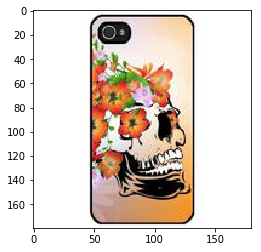

In [18]:
plt.imshow(picture)

In [15]:
categories = pd.read_csv('category_names.csv', index_col='category_id')

count_unique_cats = len(categories.index)

print("There are ", count_unique_cats, " unique categories to predict. E.g.")
print("")
print(categories.head())

There are  5270  unique categories to predict. E.g.

                         category_level1     category_level2  \
category_id                                                    
1000021794         ABONNEMENT / SERVICES      CARTE PREPAYEE   
1000012764   AMENAGEMENT URBAIN - VOIRIE  AMENAGEMENT URBAIN   
1000012776   AMENAGEMENT URBAIN - VOIRIE  AMENAGEMENT URBAIN   
1000012768   AMENAGEMENT URBAIN - VOIRIE  AMENAGEMENT URBAIN   
1000012755   AMENAGEMENT URBAIN - VOIRIE        SIGNALETIQUE   

                             category_level3  
category_id                                   
1000021794         CARTE PREPAYEE MULTIMEDIA  
1000012764                       ABRI FUMEUR  
1000012776             ABRI VELO - ABRI MOTO  
1000012768                    FONTAINE A EAU  
1000012755   PANNEAU D'INFORMATION EXTERIEUR  


In [40]:
from sklearn import preprocessing
import warnings

warnings.filterwarnings("ignore") 

#full list of classes
category_classes = categories.index.values
category_classes = category_classes.reshape(category_classes.shape[0],1)

#using a label encoder, and binarizer to convert all unique category_ids to have a column for each class 
le = preprocessing.LabelEncoder() 
lb = preprocessing.LabelBinarizer()

le.fit(category_classes)

y_encoded = le.transform(Y)

lb.fit(y_encoded)
Y_flat = lb.transform(y_encoded)

#redimension X for our model
X_flat = X_images.reshape(X_images.shape[0], -1)
Y_flat = Y_flat
m = X_flat.shape[1]
n = Y_flat.shape[1]

#Scale RGB data for learning
X_flat = X_flat/255
#print results
print("X Shape =", X_flat.shape, "Y Shape =",Y_flat.shape, "m = ",m, "n classes found in test data=", n)

X Shape = (82, 97200) Y Shape = (82, 36) m =  97200 n classes found in test data= 36


In [41]:
import tensorflow as tf

#set up params
sess = tf.Session()
seed = 2
tf.set_random_seed(2)
batch_size = 100
LEARNING_RATE = 1e-4

##nn with one layer
#set up some placeholders which we will feed data into
x = tf.placeholder(tf.float32, [None, m])
y_ = tf.placeholder(tf.float32, [None, n])

#set up a simple network - make sure the dimensions for W and b match
W = tf.Variable(tf.zeros([m, n]))
b = tf.Variable(tf.zeros([n]))
#let Y = Wx + b with a softmax activiation function
y = tf.nn.softmax(tf.matmul(x, W) + b)

#setup the minimisation pronlem with gradient descent
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

#Start a session and run
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
sess.run(train_step, feed_dict={x: X_flat, y_: Y_flat})

#have a look at the results
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#print results
print(sess.run(accuracy, feed_dict={x: X_flat, y_: Y_flat}))

0.439024


In [42]:
submission = pd.read_csv('sample_submission.csv', index_col='_id')
most_frequent_guess = 1000018296
submission['category_id'] = most_frequent_guess # Most frequent guess

In [43]:
submission.to_csv('most_freq_submission.csv.gz', compression='gzip')